In [1]:
%%capture
!pip install mujoco==2.3.3


## **Importing Required Libraries**

This cell imports all the necessary libraries for implementing **Proximal Policy Optimization (PPO)**. The key components include:

In [4]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

import torch.optim as optim
import gymnasium as gym
import numpy as np
import os
import pandas as pd

import imageio
from base64 import b64encode
from IPython.display import HTML


import logging
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
import numpy as np

if is_ipython:
    from IPython import display


## **Logging, Visualization, and Video Playback Functions**


In [5]:
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Memory Buffer for PPO**

### **Class: `Memory`**
- A **buffer** for storing experiences during training, used for **PPO (Proximal Policy Optimization) updates**.
- Stores the following per episode:
  - `actions`: Actions taken by the agent.
  - `states`: Observed states from the environment.
  - `logprobs`: Log probabilities of actions (needed for importance sampling in PPO).
  - `rewards`: Rewards obtained after taking actions.
  - `state_values`: Estimated state values from the critic.

### **Function: `clear()`**
- Clears the stored experiences before collecting new trajectories.
- Ensures memory is reset between updates to prevent stale data from affecting optimization.


In [6]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Actor-Critic Network in PPO**

This implementation defines two neural networks used in Proximal Policy Optimization (PPO).

The actor network is responsible for predicting a probability distribution over actions (discrete) or estimating the value for each action (continuous), given the current state, while the critic network evaluates how good the action taken by the actor is, by predicting the reward based on state.

In [7]:
env = gym.make("HalfCheetah-v4")
state, _ = env.reset()
print("state shape", state.shape)
print(env.action_space.sample())


state shape (17,)
[-0.24236825  0.2481937  -0.9051591   0.94084334  0.72368014  0.6389317 ]


In [8]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Parameter(torch.zeros(1,action_dim))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        std = torch.exp(self.log_std.expand_as(mu))
        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.value(x)
        return value

In [20]:
from torch.distributions import Normal
env = gym.make("HalfCheetah-v4")
state, _ = env.reset()
state = torch.FloatTensor(state).unsqueeze(0)
print("state : ", state)
print("action space : ", env.action_space.sample())
actor = Actor(17, 64, 6)
mu, std = actor(state)
print("mu : ", mu)
print("std : ", std)
dist = Normal(mu, std)
action = dist.sample()
print("action : ", action)
log_prob = dist.log_prob(action)
print("log_prob : ", log_prob)
print("squeezed action : ", action.squeeze(0).cpu().numpy())

state :  tensor([[-0.0163, -0.0120,  0.0119, -0.0894, -0.0439,  0.0375, -0.0831,  0.0167,
         -0.2002, -0.1340,  0.0798, -0.0040,  0.1180, -0.2294, -0.1453, -0.1496,
          0.1124]])
action space :  [-0.2763322  -0.20139104 -0.1643168   0.08867056  0.6788574   0.07886043]
mu :  tensor([[-0.0706, -0.0284, -0.0784, -0.1271, -0.0510, -0.0448]],
       grad_fn=<AddmmBackward0>)
std :  tensor([[1., 1., 1., 1., 1., 1.]], grad_fn=<ExpBackward0>)
action :  tensor([[-1.1988, -0.2469, -1.0033,  0.9367, -0.1367, -1.8656]])
log_prob :  tensor([[-1.5553, -0.9428, -1.3467, -1.4848, -0.9226, -2.5765]],
       grad_fn=<SubBackward0>)
squeezed action :  [-1.1987925  -0.24690042 -1.0032768   0.93672895 -0.13665944 -1.865559  ]


## **Proximal Policy Optimization (PPO) Algorithm Implementation**

This class implements the **PPO (Proximal Policy Optimization) algorithm**, which is a policy gradient method used in reinforcement learning. It optimizes an actor-critic network while maintaining stability and efficiency.

### **Key Components:**
1. **Initialization (`__init__`)**:
   - Sets hyperparameters (e.g., `gamma`, `eps_clip`, `gae_lambda`).
   - Creates **Actor and Critic networks**.
   - Defines **Adam optimizers** for both networks.
   - Initializes a memory buffer for storing experience.

2. **Action Selection (`select_action`)**:
   - Uses the **Actor network** to predict a mean and standard deviation for the action.
   - Samples an action from a normal distribution.
   - Stores the action, log probability, and value function output in memory.

3. **Policy Evaluation (`evaluate`)**:
   - Computes the log probability of actions under the current policy.
   - Returns entropy (used for exploration encouragement).

4. **Policy Update (`update`)**:
   - Computes **discounted rewards** and **Generalized Advantage Estimation (GAE)**.
   - Uses **clipped surrogate objective** to stabilize training.
   - Minimizes **actor loss** (policy update) and **critic loss** (value function update).
   - Updates networks using **gradient descent**.

5. **Memory Handling (`push_memory`, `load_memory`, `store_reward`)**:
   - Stores and retrieves experience for training updates.
   - Resets the memory buffer after each policy update.

### **Key Features of PPO**
- **Clipping Ratio**: Prevents excessive updates to the policy, improving stability.
- **Advantage Estimation**: Helps in reducing variance in policy updates.
- **Entropy Regularization**: Encourages exploration by adding entropy loss.


## **1. PPO Clipped Loss Function**
The PPO loss function prevents large policy updates by introducing a clipped objective. The ratio of new and old policy probabilities is computed as:
$$
r_t(\theta) = \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$
where:
- $ \theta $ are the current policy parameters.
- $\theta_{\text{old}} $ are the policy parameters before the update.

The surrogate loss function is:
$$
L^{\text{CLIP}}(\theta) = \mathbb{E} \left[ \min \left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$
where:
- $ A_t $ is the **advantage function**, which measures how much better an action is compared to the expected value of the state.
- $ \epsilon $ is a small clipping parameter (e.g., **0.2**) that prevents drastic policy updates.

---

## **2. Critic Loss Function**
The critic is updated using **Mean Squared Error (MSE)** between the predicted and actual state value:
$$
L_{\text{critic}} = \mathbb{E} \left[ (V(s_t) - R_t)^2 \right]
$$

---

## **3. Total Loss**
The overall loss function is:
$$
L_{\text{total}} = L^{\text{CLIP}} + \beta H - L_{\text{critic}}
$$
where:
- $ H $ is the **entropy bonus** to encourage exploration.
- $ \beta $ is a small coefficient (e.g., **0.01**) controlling the strength of the entropy bonus.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PPO(nn.Module):
    def __init__(self, env, config):
        super(PPO, self).__init__()
        self.gamma = config.GAMMA
        self.eps_clip = config.EPS_CLIP
        self.epochs = config.K_EPOCHS
        self.gae_lambda = config.GAE
        self.hidden_size = config.hidden_size
        self.lr = config.LEARNING_RATE

        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.actor = Actor(state_dim, self.hidden_size, action_dim).to(device)
        self.critic = Critic(state_dim, self.hidden_size).to(device)

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr)
        self.memory = Memory()

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mu, std = self.actor(state)
        dist = Normal(mu, std)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        value = self.critic(state)
        self.push_memory(state, action, action_logprob, value)
        return action.squeeze(0).cpu().numpy()

    def evaluate(self, state, action):
        mu, std = self.actor(state)
        dist = Normal(mu, std)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        return action_logprobs, state_value, dist_entropy

    def _compute_gae(self, rewards, state_values):
        advantages = []
        gae = 0
        next_value = 0

        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * next_value - state_values[i]
            gae = delta + self.gamma * self.gae_lambda * gae
            advantages.insert(0, gae)
            next_value = state_values[i]

        advantages = torch.tensor(advantages, dtype=torch.float32, device=device)
        returns = state_values.squeeze(-1) + advantages.unsqueeze(-1)
        return advantages, returns

    def update(self):
        # Load stored data from memory.
        last_states, last_actions, last_logprobs, last_state_values = self.load_memory()
        rewards = self.memory.rewards

        # Compute advantages and returns.
        advantages, returns = self._compute_gae(rewards, last_state_values)
        # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        total_loss_actor = 0
        total_loss_critic = 0
        entropy_coef = 0.001

        for _ in range(self.epochs):
            logprobs, state_values, entropy = self.evaluate(last_states, last_actions)
            
            state_values = state_values.squeeze(-1)
            logprobs = logprobs.squeeze(1)
            last_logprobs = last_logprobs.squeeze(1)
            entropy = entropy.squeeze(1)
            
            ratios = torch.exp(logprobs.sum(dim=-1) - last_logprobs.sum(dim=-1).detach())
            loss_actor = -torch.min(ratios * advantages, torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages) - entropy_coef * entropy.sum(dim=-1)
            loss_critic = F.mse_loss(state_values, returns)
            
            loss_actor_mean = loss_actor.mean()
            self.optimizer_actor.zero_grad()
            loss_actor_mean.backward(retain_graph=True)
            self.optimizer_actor.step()

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            self.optimizer_critic.step()

            total_loss_actor += loss_actor_mean.item()
            total_loss_critic += loss_critic.item()

        # Clear the memory after update.
        self.memory.clear()
        return total_loss_actor, total_loss_critic

    def push_memory(self, state, action, log_prob, value):
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(log_prob)
        self.memory.state_values.append(value)

    def load_memory(self):
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()
        old_state_vals = torch.stack(self.memory.state_values).detach()
        return old_states, old_actions, old_logprobs, old_state_vals

    def store_reward(self, reward):
        self.memory.rewards.append(reward)


## **Configuration Settings for PPO Training**

The `Config` class defines **hyperparameters and settings** for training the PPO agent in a reinforcement learning environment.


In [15]:
class Config:
    # Environment settings
    SEED = 111
    MAX_EPISODES = 3000 #TODO
    

    # PPO Hyperparameters
    K_EPOCHS = 16
    EPS_CLIP = 0.2
    GAMMA = 0.99
    LEARNING_RATE = 3e-4#TODO
    BETAS = (0.9, 0.99)

    hidden_size= 128#TODO
    GAE = 0.95#TODO

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Proximal Policy Optimization (PPO) Training on HalfCheetah-v4 Environment**

This notebook implements and trains a **Proximal Policy Optimization (PPO)** agent on the **HalfCheetah-v4** environment. The PPO algorithm is an on-policy reinforcement learning method that uses a clipped objective function to update the policy in a stable way.

Training Progress:   0%|          | 1/3000 [00:01<53:29,  1.07s/it, Latest Reward=-602, Actor Loss=181, Critic Loss=2.34e+3]

Episode 0 -> Reward: -602.09 | Actor Loss: 180.682371 | Critic Loss: 2344.797722


Training Progress:   3%|▎         | 101/3000 [01:49<53:19,  1.10s/it, Latest Reward=-476, Actor Loss=8.15, Critic Loss=1.39e+3] 

Episode 100 -> Reward: -476.11 | Actor Loss: 8.153535 | Critic Loss: 1390.352859


Training Progress:   7%|▋         | 201/3000 [03:37<49:58,  1.07s/it, Latest Reward=-202, Actor Loss=28.8, Critic Loss=779]      

Episode 200 -> Reward: -201.76 | Actor Loss: 28.794100 | Critic Loss: 778.500664


Training Progress:  10%|█         | 301/3000 [05:24<47:59,  1.07s/it, Latest Reward=203, Actor Loss=-1.71, Critic Loss=1.32e+3]  

Episode 300 -> Reward: 202.66 | Actor Loss: -1.713642 | Critic Loss: 1317.969940


Training Progress:  13%|█▎        | 401/3000 [07:10<46:00,  1.06s/it, Latest Reward=608, Actor Loss=0.735, Critic Loss=1.96e+3]

Episode 400 -> Reward: 608.05 | Actor Loss: 0.735174 | Critic Loss: 1962.293549


Training Progress:  17%|█▋        | 501/3000 [08:57<43:53,  1.05s/it, Latest Reward=868, Actor Loss=-5.27, Critic Loss=3.1e+3]     

Episode 500 -> Reward: 868.05 | Actor Loss: -5.274881 | Critic Loss: 3101.490891


Training Progress:  20%|██        | 601/3000 [10:44<42:14,  1.06s/it, Latest Reward=1.18e+3, Actor Loss=-0.829, Critic Loss=4.14e+3]

Episode 600 -> Reward: 1180.30 | Actor Loss: -0.829443 | Critic Loss: 4143.045914


Training Progress:  23%|██▎       | 701/3000 [12:30<40:41,  1.06s/it, Latest Reward=1.57e+3, Actor Loss=-32.8, Critic Loss=6.35e+3] 

Episode 700 -> Reward: 1565.22 | Actor Loss: -32.767602 | Critic Loss: 6346.226013


Training Progress:  27%|██▋       | 801/3000 [14:17<38:58,  1.06s/it, Latest Reward=1.87e+3, Actor Loss=-48.5, Critic Loss=7.65e+3]

Episode 800 -> Reward: 1865.91 | Actor Loss: -48.482978 | Critic Loss: 7650.961212


Training Progress:  30%|███       | 901/3000 [16:04<37:46,  1.08s/it, Latest Reward=1.93e+3, Actor Loss=-53.4, Critic Loss=8.55e+3]

Episode 900 -> Reward: 1932.01 | Actor Loss: -53.440233 | Critic Loss: 8551.844482


Training Progress:  33%|███▎      | 1001/3000 [17:50<35:37,  1.07s/it, Latest Reward=2.12e+3, Actor Loss=-71.3, Critic Loss=1.02e+4]

Episode 1000 -> Reward: 2119.34 | Actor Loss: -71.327476 | Critic Loss: 10207.432617


Training Progress:  37%|███▋      | 1101/3000 [19:37<33:33,  1.06s/it, Latest Reward=2.28e+3, Actor Loss=-78.9, Critic Loss=1.16e+4] 

Episode 1100 -> Reward: 2283.82 | Actor Loss: -78.903715 | Critic Loss: 11590.112671


Training Progress:  40%|████      | 1201/3000 [21:24<31:53,  1.06s/it, Latest Reward=2.03e+3, Actor Loss=-29, Critic Loss=1.15e+4]  

Episode 1200 -> Reward: 2025.76 | Actor Loss: -29.019325 | Critic Loss: 11507.601868


Training Progress:  43%|████▎     | 1301/3000 [23:10<29:42,  1.05s/it, Latest Reward=1.26e+3, Actor Loss=49.9, Critic Loss=1.56e+4]  

Episode 1300 -> Reward: 1261.21 | Actor Loss: 49.921255 | Critic Loss: 15627.534546


Training Progress:  47%|████▋     | 1401/3000 [24:56<29:16,  1.10s/it, Latest Reward=2.2e+3, Actor Loss=-4.81, Critic Loss=1.33e+4] 

Episode 1400 -> Reward: 2202.35 | Actor Loss: -4.809071 | Critic Loss: 13257.353271


Training Progress:  50%|█████     | 1501/3000 [26:42<26:36,  1.06s/it, Latest Reward=2.33e+3, Actor Loss=-7.33, Critic Loss=1.46e+4]

Episode 1500 -> Reward: 2331.30 | Actor Loss: -7.330335 | Critic Loss: 14608.211731


Training Progress:  53%|█████▎    | 1601/3000 [28:28<24:27,  1.05s/it, Latest Reward=2.64e+3, Actor Loss=-105, Critic Loss=1.47e+4]  

Episode 1600 -> Reward: 2643.69 | Actor Loss: -104.591825 | Critic Loss: 14725.755920


Training Progress:  57%|█████▋    | 1701/3000 [30:14<22:56,  1.06s/it, Latest Reward=-625, Actor Loss=204, Critic Loss=1.36e+4]      

Episode 1700 -> Reward: -624.61 | Actor Loss: 203.831976 | Critic Loss: 13593.573914


Training Progress:  60%|██████    | 1801/3000 [32:01<21:06,  1.06s/it, Latest Reward=2.52e+3, Actor Loss=-44.7, Critic Loss=1.56e+4]

Episode 1800 -> Reward: 2519.82 | Actor Loss: -44.693507 | Critic Loss: 15617.071655


Training Progress:  63%|██████▎   | 1901/3000 [33:47<20:20,  1.11s/it, Latest Reward=2.4e+3, Actor Loss=0.107, Critic Loss=2.16e+4]  

Episode 1900 -> Reward: 2398.94 | Actor Loss: 0.106673 | Critic Loss: 21563.710938


Training Progress:  67%|██████▋   | 2001/3000 [35:32<17:28,  1.05s/it, Latest Reward=-132, Actor Loss=94.1, Critic Loss=1.41e+4]    

Episode 2000 -> Reward: -132.25 | Actor Loss: 94.120040 | Critic Loss: 14059.426086


Training Progress:  70%|███████   | 2101/3000 [37:18<15:39,  1.04s/it, Latest Reward=2.51e+3, Actor Loss=14.4, Critic Loss=1.66e+4]  

Episode 2100 -> Reward: 2508.03 | Actor Loss: 14.369126 | Critic Loss: 16635.365845


Training Progress:  73%|███████▎  | 2201/3000 [39:04<14:30,  1.09s/it, Latest Reward=2.79e+3, Actor Loss=-48.1, Critic Loss=1.69e+4]

Episode 2200 -> Reward: 2786.62 | Actor Loss: -48.084059 | Critic Loss: 16890.359009


Training Progress:  77%|███████▋  | 2301/3000 [40:50<12:14,  1.05s/it, Latest Reward=2.77e+3, Actor Loss=-73.6, Critic Loss=1.84e+4]

Episode 2300 -> Reward: 2770.16 | Actor Loss: -73.573915 | Critic Loss: 18364.587769


Training Progress:  80%|████████  | 2401/3000 [42:36<10:29,  1.05s/it, Latest Reward=2.49e+3, Actor Loss=21.3, Critic Loss=1.51e+4]  

Episode 2400 -> Reward: 2491.10 | Actor Loss: 21.349295 | Critic Loss: 15136.347656


Training Progress:  83%|████████▎ | 2501/3000 [44:22<08:52,  1.07s/it, Latest Reward=2.74e+3, Actor Loss=15.9, Critic Loss=1.89e+4]  

Episode 2500 -> Reward: 2738.70 | Actor Loss: 15.942540 | Critic Loss: 18918.110474


Training Progress:  87%|████████▋ | 2601/3000 [46:07<06:58,  1.05s/it, Latest Reward=2.92e+3, Actor Loss=-40.9, Critic Loss=1.94e+4]

Episode 2600 -> Reward: 2919.37 | Actor Loss: -40.923154 | Critic Loss: 19405.924561


Training Progress:  90%|█████████ | 2701/3000 [47:55<05:23,  1.08s/it, Latest Reward=2.28e+3, Actor Loss=55.8, Critic Loss=1.99e+4]  

Episode 2700 -> Reward: 2280.23 | Actor Loss: 55.832778 | Critic Loss: 19931.268433


Training Progress:  93%|█████████▎| 2801/3000 [49:41<03:30,  1.06s/it, Latest Reward=2.49e+3, Actor Loss=-30.3, Critic Loss=2.07e+4]

Episode 2800 -> Reward: 2492.28 | Actor Loss: -30.269138 | Critic Loss: 20681.489380


Training Progress:  97%|█████████▋| 2901/3000 [51:27<01:44,  1.06s/it, Latest Reward=2.92e+3, Actor Loss=-76.1, Critic Loss=1.85e+4]

Episode 2900 -> Reward: 2918.52 | Actor Loss: -76.067556 | Critic Loss: 18454.249023


Training Progress: 100%|██████████| 3000/3000 [53:13<00:00,  1.06s/it, Latest Reward=2.86e+3, Actor Loss=-82.4, Critic Loss=2.01e+4]  


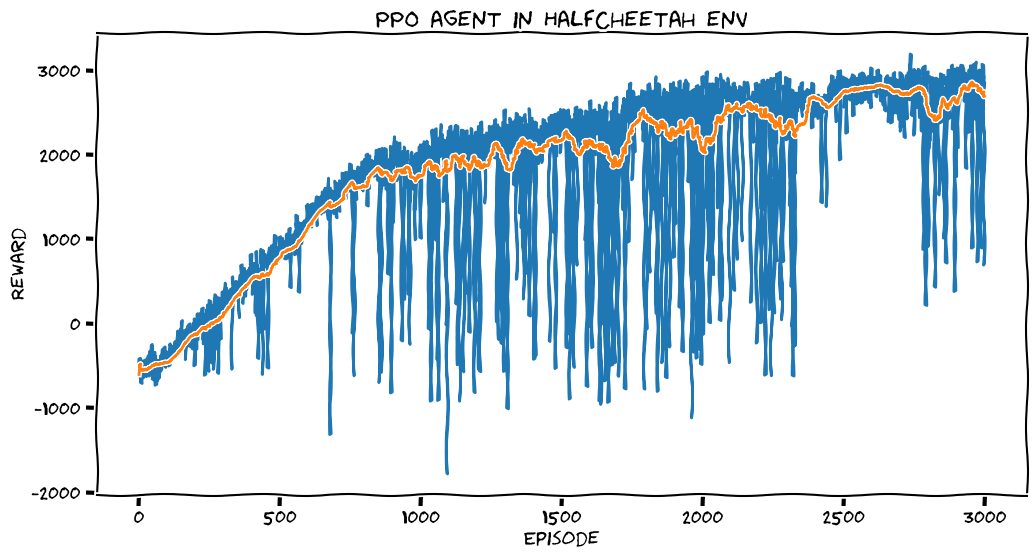

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [18]:
from tqdm import trange

env = gym.make("HalfCheetah-v4")
config = Config()

agent = PPO(env, config)

# Tracking losses and rewards
actor_losses = []
critic_losses = []
rewards_history = []

# Using tqdm for progress tracking
with trange(config.MAX_EPISODES, desc="Training Progress") as t:
    for episode in t:
        state, _ = env.reset()
        episode_reward = 0
        done = False
        i = 0
        
        while not done and i < 800:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            done = done or truncated
            agent.store_reward(reward)
            episode_reward += reward
            state = next_state
            i += 1

        # Update the agent and store losses
        loss_ac, loss_cri = agent.update()
        actor_losses.append(loss_ac)
        critic_losses.append(loss_cri)
        rewards_history.append(episode_reward)

        # Update tqdm progress bar with the latest reward
        t.set_postfix({"Latest Reward": episode_reward, "Actor Loss": loss_ac, "Critic Loss": loss_cri})

        # Print detailed progress every 50 episodes
        if episode % 100 == 0:
            print(f'Episode {episode} -> Reward: {episode_reward:.2f} | Actor Loss: {loss_ac:.6f} | Critic Loss: {loss_cri:.6f}')

env.close()

plot_rewards(rewards_history, show_result='PPO agent in HalfCheetah env')


# **Evaluating the PPO Agent in the HalfCheetah-v4 Environment**

In [22]:
# Create environment
%env MUJOCO_GL=egl
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
frames = []

state, info = env.reset()
done = False
total_reward = 0

# run the learned PPO agent to evaluate it
#TODO 
i = 0
while not done and i < 1000:
    frame = env.render()
    frames.append(frame)
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward: {total_reward}")

# Save frames as a video
video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)

# Display the video
show_video(video_path)

env: MUJOCO_GL=egl
Total Reward: 3606.1060950389506
